### Diffusion Model inference

In [1]:
import warnings
warnings.filterwarnings('ignore')

import jax
import functools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from tqdm import tqdm
from read_data import get_cond_ecmwf_dataset, get_mean_std_data
from swirl_dynamics.lib import diffusion as dfn_lib
from swirl_dynamics.lib import solvers as solver_lib
from swirl_dynamics.projects import probabilistic_diffusion as dfn
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

2024-05-07 21:24:53.462497: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
ecmwf = xr.open_mfdataset('data/test/*.zarr').ecmwf.load()
chirps = xr.open_mfdataset('data/test/*.zarr').chirps.load()

In [3]:
cond_workdir = "/home/u/amine.barkaoui/chkpts/cond_diffusion_ecmwf_nonorm" #fixstd_1"

DATA_STD = 43 #1

num_samples_per_cond = 25

In [4]:
diffusion_scheme = dfn_lib.Diffusion.create_variance_exploding(
    sigma=dfn_lib.tangent_noise_schedule(),
    data_std=DATA_STD,
)

In [5]:
cond_denoiser_model = dfn_lib.PreconditionedDenoiser(
    out_channels=1,
    num_channels=(64, 128),
    downsample_ratio=(2, 2),
    num_blocks=4,
    noise_embed_dim=128,
    padding="SAME",
    use_attention=True,
    use_position_encoding=True,
    num_heads=8,
    sigma_data=DATA_STD,
    cond_resize_method="cubic",
    cond_embed_dim=128,
)

In [6]:
trained_state = dfn.DenoisingModelTrainState.restore_from_orbax_ckpt(
    f"{cond_workdir}/checkpoints", step=None
)
# Construct the inference function
cond_denoise_fn = dfn.DenoisingTrainer.inference_fn_from_state_dict(
    trained_state, use_ema=True, denoiser=cond_denoiser_model
)

cond_sampler = dfn_lib.SdeSampler(
    input_shape=(28, 28, 1),
    integrator=solver_lib.EulerMaruyama(),
    tspan=dfn_lib.edm_noise_decay(
        diffusion_scheme, rho=7, num_steps=256, end_sigma=1e-3,
    ),
    scheme=diffusion_scheme,
    denoise_fn=cond_denoise_fn,
    guidance_transforms=(),
    apply_denoise_at_end=True,
    return_full_paths=False,
)

2024-05-07 21:25:04.696505: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [7]:
generate = jax.jit(
    functools.partial(cond_sampler.generate, num_samples_per_cond)
)

In [8]:
batch_size = ecmwf.time.size

In [9]:
%%time

test_ds = iter(get_cond_ecmwf_dataset(split="test", batch_size=batch_size))

batch_test = next(test_ds)

test_batch_cond = batch_test["cond"]

cond_samples = jax.vmap(generate, in_axes=(0, 0, None))(
    jax.random.split(jax.random.PRNGKey(8888), batch_size),
    test_batch_cond,
    None,  # Guidance inputs = None since no guidance transforms involved
)

np.save(f"data/diffusion/batch_{num_samples_per_cond}samples_nonorm", cond_samples)

2024-05-07 21:25:12.547430: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-05-07 21:25:58.997671: W external/tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-07 21:26:01.228185: W external/tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 14.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were availa

CPU times: user 5min 20s, sys: 2min 12s, total: 7min 33s
Wall time: 7min 9s


#### Visualization

In [13]:
mean_chirps, var_chirps, mean_ecmwf, var_ecmwf = get_mean_std_data()

In [14]:
var_chirps

43.61971025792173

In [10]:
# Benchmarks
qm = xr.open_zarr("data/benchmarks_results/QM/test_quantile_mapping.zarr").scen
bilint = xr.open_zarr("data/benchmarks_results/bilinear/test_bilinear.zarr").bilint

batch_test = next(iter(get_cond_ecmwf_dataset(split="test", batch_size=batch_size)))

test_batch_cond = batch_test["cond"]['channel:low_res']
test_batch_gt = batch_test["x"]

test_batch_cond = test_batch_cond #* (var_ecmwf + 1e-4) + mean_ecmwf
test_batch_gt = test_batch_gt #* (var_chirps + 1e-4) + mean_chirps

xx = np.load(f"data/diffusion/batch_25samples_nonorm.npy") #* (var_chirps + 1e-4) + mean_chirps

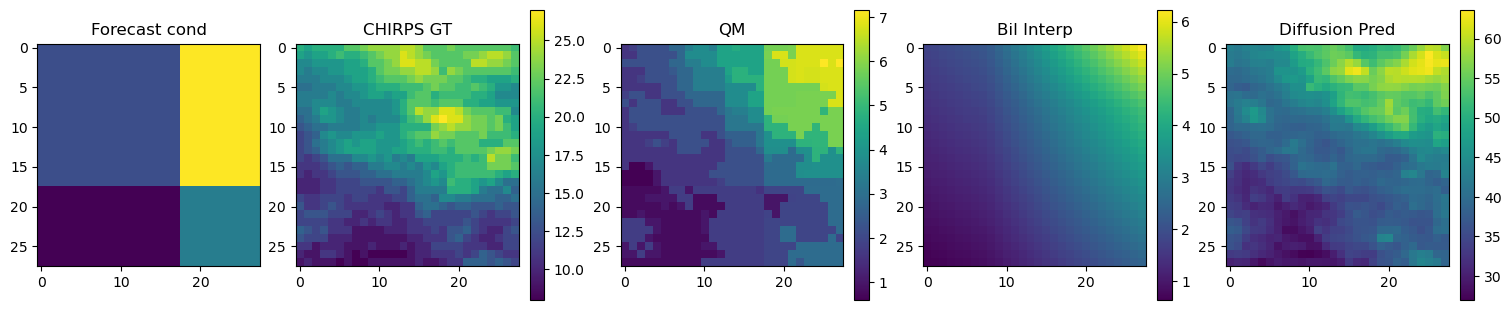

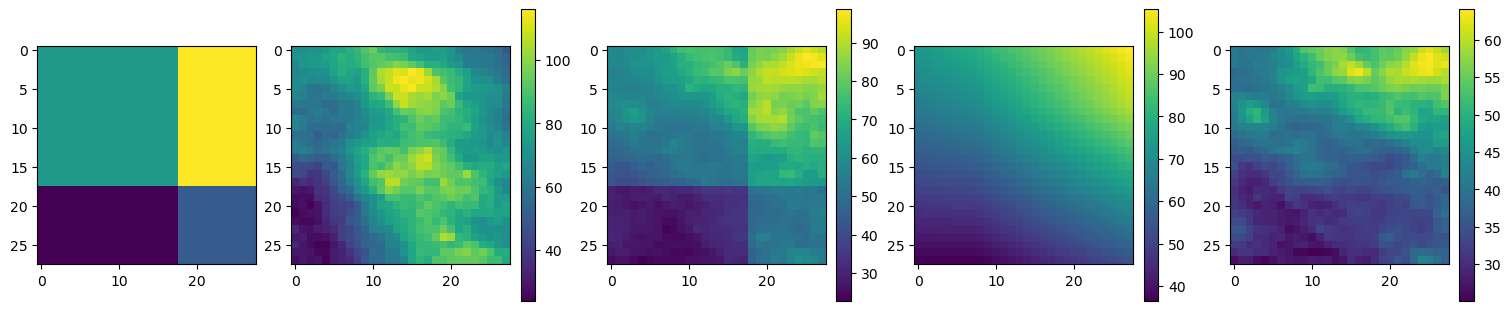

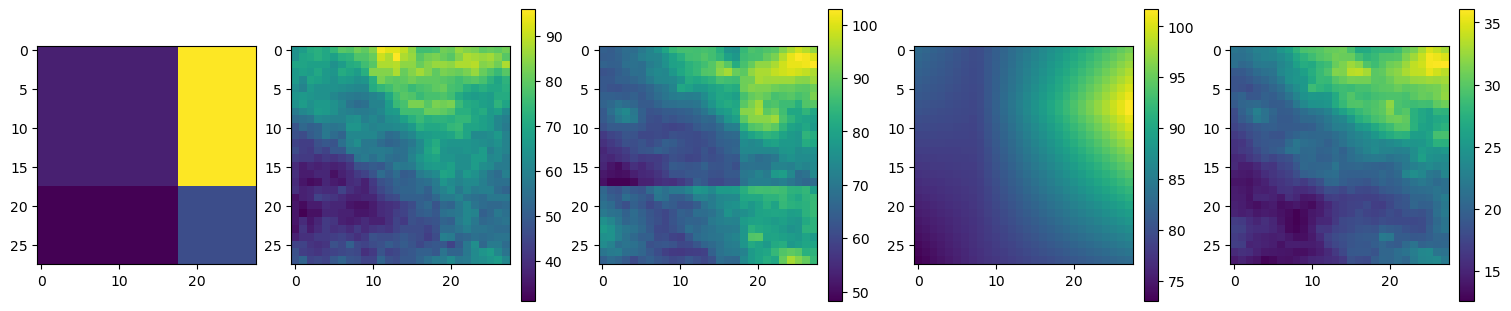

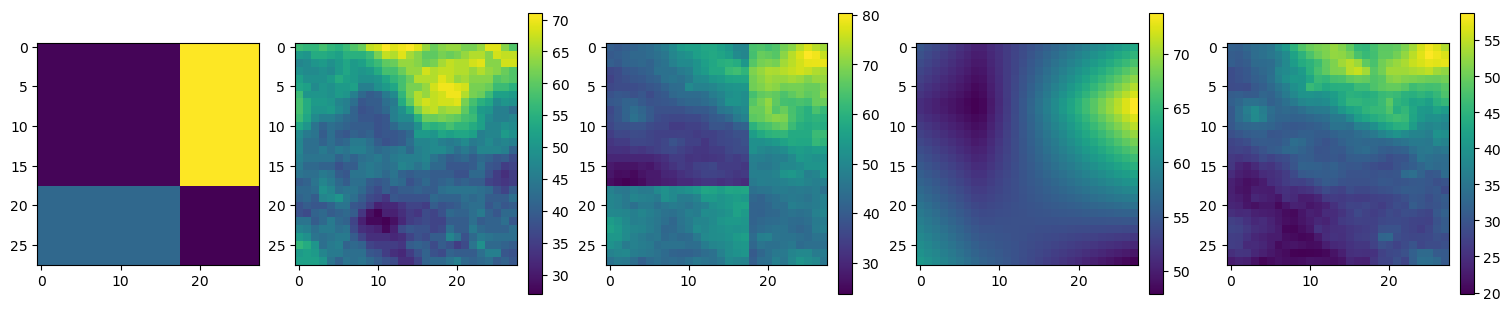

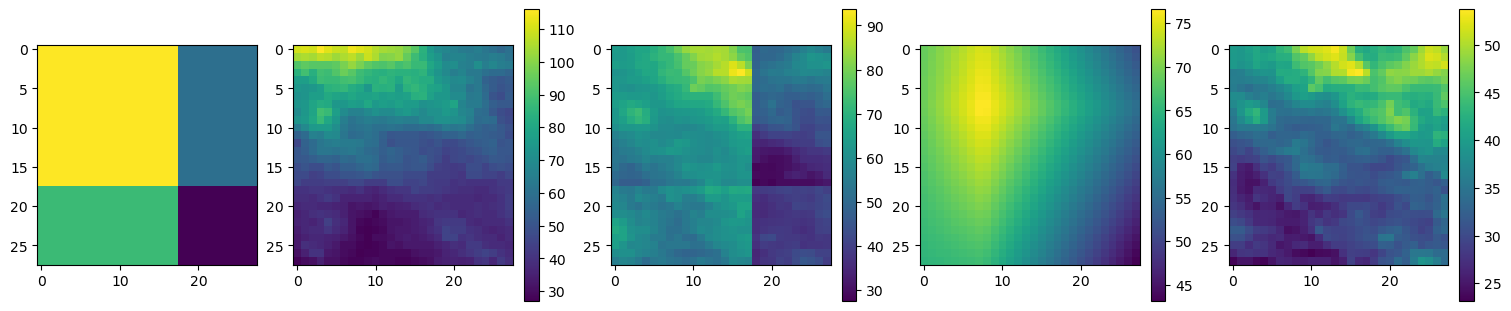

In [11]:
start = 0
end = 10

for b in range(start, end*10, 20):
    fig, ax = plt.subplots(1, 5, constrained_layout=True, figsize=(15, 3))
      
    mini = None #np.min(test_batch_gt[b,:,:])
    maxi = None #np.max(test_batch_gt[b,:,:])

    ax[0].imshow(test_batch_cond[b,:,:])
    #ax[1].imshow(ecmwf.isel(time=b).values)
    im = ax[1].imshow(test_batch_gt[b,:,:], vmin=mini, vmax=maxi)
    fig.colorbar(im, ax=ax[1])
    im = ax[2].imshow(qm.isel(time=b).values, vmin=mini, vmax=maxi)
    fig.colorbar(im, ax=ax[2])
    im = ax[3].imshow(bilint.isel(time=b).values, vmin=mini, vmax=maxi)
    fig.colorbar(im, ax=ax[3])
    im = ax[4].imshow(np.mean(xx, axis=1)[b,:,:,0], vmin=mini, vmax=maxi)
    fig.colorbar(im, ax=ax[4])
    
    if b == start:
        ax[0].set_title("Forecast cond")
        ax[1].set_title("CHIRPS GT")
        ax[2].set_title("QM")
        ax[3].set_title("Bil Interp")
        ax[4].set_title("Diffusion Pred")
        
plt.show()

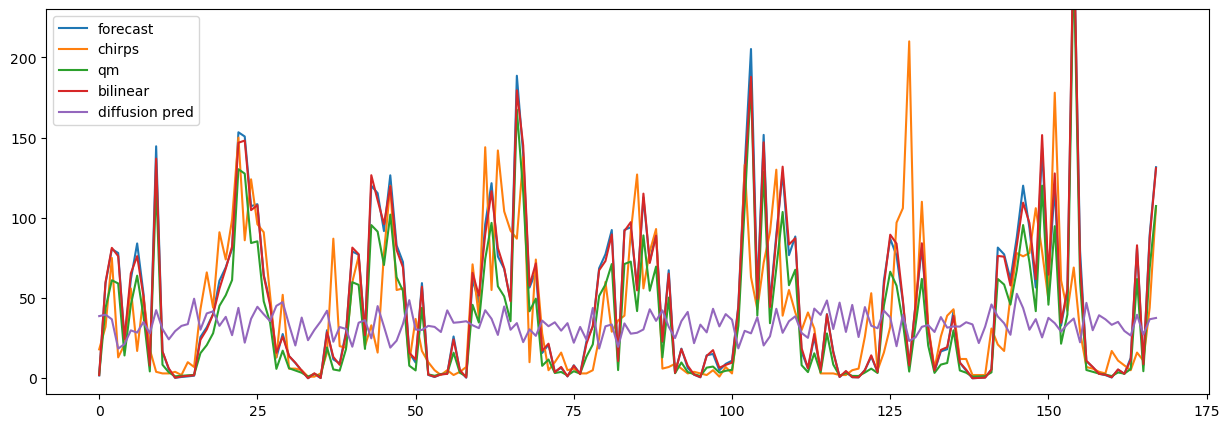

In [12]:
pix_lon_index = 10
pix_lat_index = 10

plt.figure(figsize=(15, 5))

plt.plot(test_batch_cond[:,pix_lat_index,pix_lon_index], label='forecast')
plt.plot(test_batch_gt[:,pix_lat_index,pix_lon_index], label='chirps')
plt.plot(qm.isel(longitude=pix_lon_index, latitude=pix_lat_index).values, label='qm')
plt.plot(bilint.isel(longitude=pix_lon_index, latitude=pix_lat_index).values, label='bilinear')
plt.plot(np.mean(xx, axis=1)[:,pix_lat_index,pix_lon_index,0], label='diffusion pred')

plt.ylim(-10, 230)
plt.legend()
        
plt.show()

##### **Inference on training dataset for SPI**

In [8]:
train_input = xr.open_mfdataset('data/train/*.zarr').ecmwf.load()

/envs/user/swirl/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/envs/user/swirl/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/envs/user/swirl/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/envs/user/swirl/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/envs/user/swirl/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/envs/user/swirl/lib/python3.11/site-pa

In [10]:
n_iter = 7
batch_size = train_input.time.size // n_iter

In [11]:
%%time

train_ds = iter(get_cond_ecmwf_dataset(split="train", batch_size=batch_size))

for batch in range(n_iter):

    batch_train = next(train_ds)

    train_batch_cond = batch_train["cond"]

    cond_samples = jax.vmap(generate, in_axes=(0, 0, None))(
        jax.random.split(jax.random.PRNGKey(8888), batch_size),
        train_batch_cond,
        None,  # Guidance inputs = None since no guidance transforms involved
    )

    np.save(f"data/diffusion/batch_train_{batch}.py", cond_samples)

2024-03-28 15:30:04.415795: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


CPU times: user 18min 30s, sys: 8min 54s, total: 27min 25s
Wall time: 27min 7s
